<a href="https://colab.research.google.com/github/SuhailSumra/Deep-Learning-Projects/blob/main/DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.applications import inception_v3

In [4]:
base_image_path = keras.utils.get_file("suhail.jpg", "https://pbs.twimg.com/profile_images/1170993238699905024/mukWsa6w_400x400.jpg")
result_prefix = "suhail_dream"

layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5
}

step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 15.0

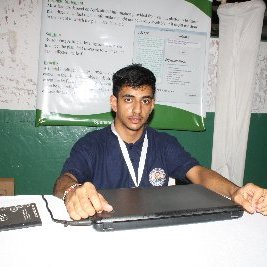

In [10]:
from IPython.display import Image, display
display(Image(base_image_path))

In [11]:
def preprocess_image(image_path):
  img = keras.preprocessing.image.load_img(base_image_path)
  img = keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = inception_v3.preprocess_input(img)
  return img

def deprocess_image(x):
  x = x.reshape((x.shape[1], x.shape[2], 3))
  x /= 2.0
  x += 0.5
  x *= 255.0
  x = np.clip(x, 0, 255).astype("uint8")
  return x

In [13]:
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

output_dict = dict (
    [
     (layer.name, layer.output)
     for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
) 

feature_extractor = keras.Model(inputs=model.inputs, outputs=output_dict)

In [14]:
def compute_loss(input_image):
  features = feature_extractor(input_image)
  loss = tf.zeros(shape=())
  for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]
    scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
    loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
  return loss

In [19]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img

In [20]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  # Make a copy
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy()))

Processing octave 0 with shape (136, 136)
... Loss value at step 0: 0.38
... Loss value at step 1: 0.63
... Loss value at step 2: 0.87
... Loss value at step 3: 1.02
... Loss value at step 4: 1.16
... Loss value at step 5: 1.33
... Loss value at step 6: 1.37
... Loss value at step 7: 1.57
... Loss value at step 8: 1.66
... Loss value at step 9: 1.76
... Loss value at step 10: 1.90
... Loss value at step 11: 2.05
... Loss value at step 12: 2.26
... Loss value at step 13: 2.42
... Loss value at step 14: 2.60
... Loss value at step 15: 2.77
... Loss value at step 16: 2.97
... Loss value at step 17: 3.10
... Loss value at step 18: 3.33
... Loss value at step 19: 3.46
Processing octave 1 with shape (190, 190)
... Loss value at step 0: 0.92
... Loss value at step 1: 1.50
... Loss value at step 2: 1.91
... Loss value at step 3: 2.18
... Loss value at step 4: 2.28
... Loss value at step 5: 2.65
... Loss value at step 6: 2.90
... Loss value at step 7: 3.10
... Loss value at step 8: 3.40
... Los

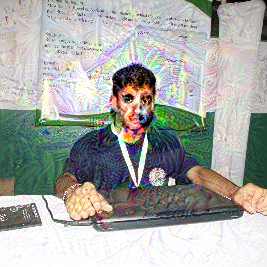

In [21]:
display(Image(result_prefix + '.png'))